Starting complete DeFi credit scoring analysis...
Loading transaction data...
Loaded 100000 transactions
Data preprocessing completed
Engineering features for each wallet...
Features engineered for 3497 wallets
Training credit scoring model...
Creating synthetic credit score labels...
Model Training R²: 0.9915
Model Test R²: 0.9836

Top 10 Most Important Features:
                    feature  importance
23            time_variance    0.774959
0        total_transactions    0.105344
22     avg_time_between_txs    0.031455
20    repay_to_borrow_ratio    0.027857
21       hour_concentration    0.017214
17             repay_volume    0.009365
14            unique_assets    0.006809
19  borrow_to_deposit_ratio    0.005420
6                    repays    0.004840
11           median_tx_size    0.004275
Generating credit scores for all wallets...
Generated scores for 3497 wallets
Analyzing credit scores...


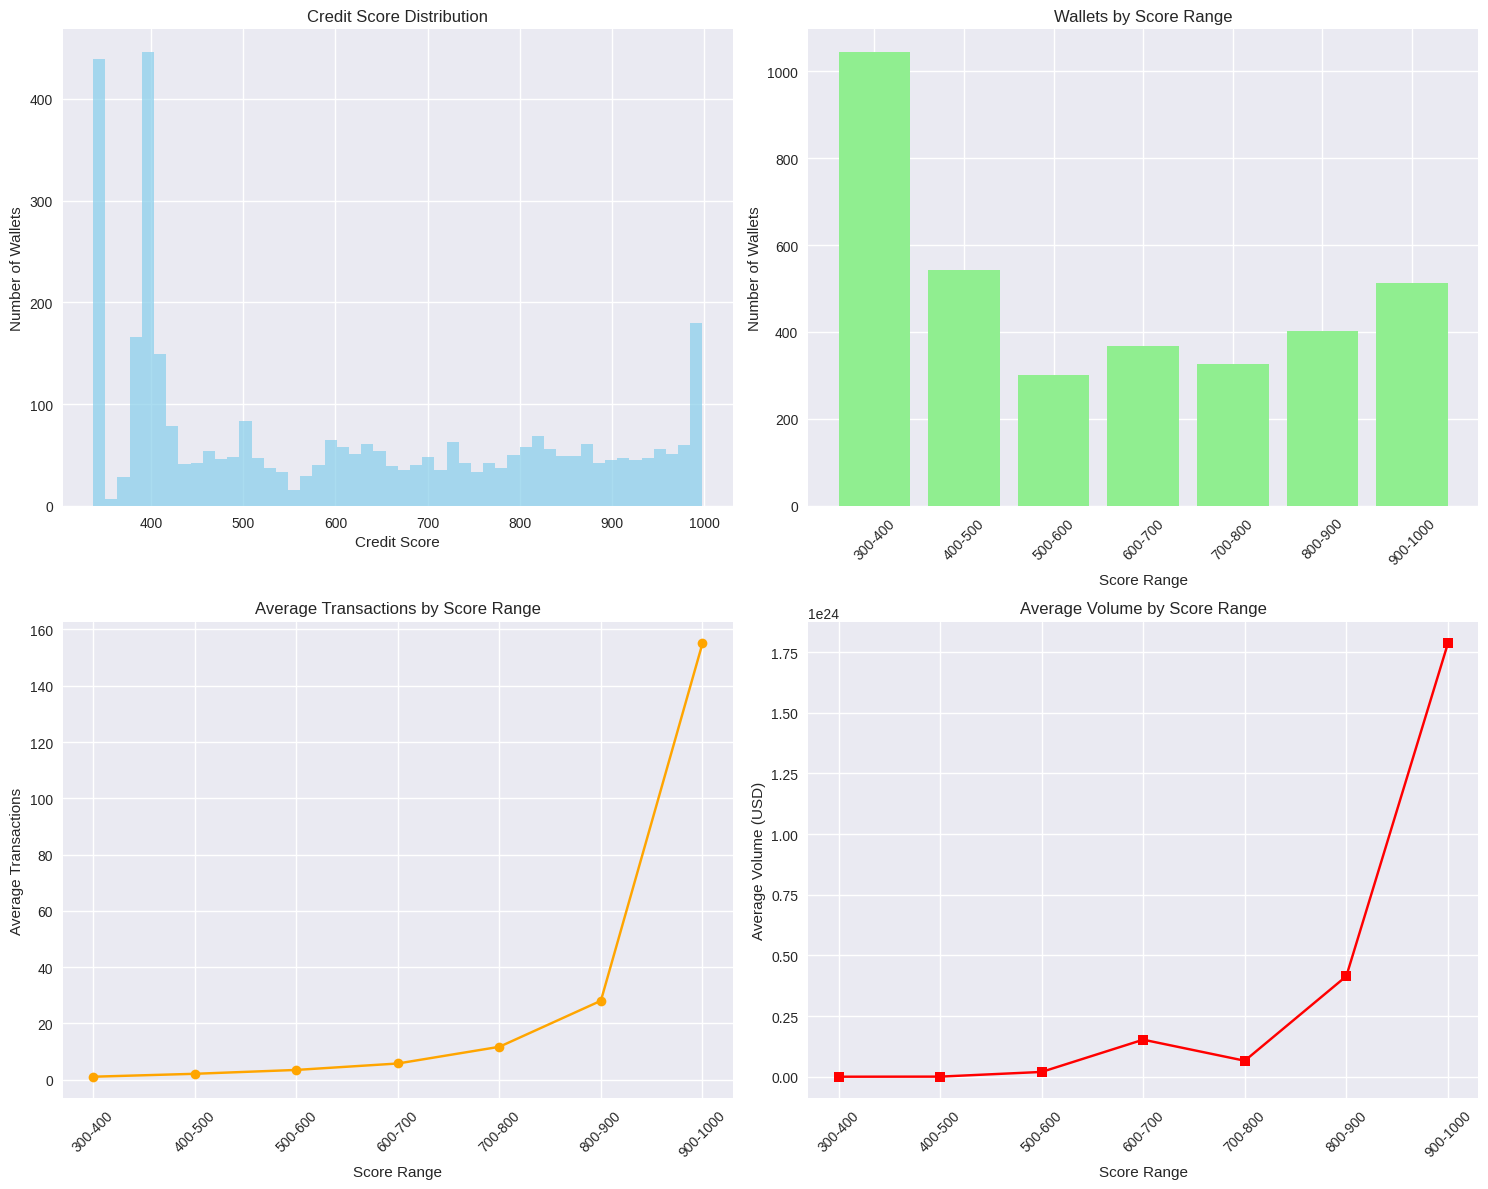


Score Range Analysis:
  score_range  wallet_count  avg_transactions    avg_volume  \
0     300-400          1044          1.049808  2.466353e+20   
1     400-500           542          2.083026  6.234311e+20   
2     500-600           301          3.458472  1.992173e+22   
3     600-700           368          5.744565  1.528824e+23   
4     700-800           327         11.678899  6.605279e+22   
5     800-900           402         28.047264  4.144463e+23   
6    900-1000           513        155.021442  1.785681e+24   

   avg_liquidation_ratio  avg_repay_ratio  avg_account_age  
0               0.000000     0.000000e+00         1.028736  
1               0.000000     1.437755e+19         3.304428  
2               0.006202     2.129872e-01         9.614618  
3               0.010405     2.237924e+15        19.921196  
4               0.011312     4.340258e-01        34.868502  
5               0.004931     6.153562e-01        42.087065  
6               0.002308     6.857471e-01    

In [1]:
# DeFi Credit Scoring Model for Aave V2 Transactions
# Complete implementation for wallet credit scoring based on transaction behavior

import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class DeFiCreditScorer:
    def __init__(self, data_path):
        """
        Initialize the DeFi Credit Scorer

        Args:
            data_path (str): Path to the JSON file containing transaction data
        """
        self.data_path = data_path
        self.raw_data = None
        self.processed_data = None
        self.wallet_features = None
        self.model = None
        self.scaler = None
        self.wallet_scores = None

    def load_data(self):
        """Load and parse JSON transaction data"""
        print("Loading transaction data...")

        with open(self.data_path, 'r') as f:
            self.raw_data = json.load(f)

        print(f"Loaded {len(self.raw_data)} transactions")

        # Convert to DataFrame for easier processing
        self.processed_data = pd.DataFrame(self.raw_data)

        # Parse timestamps
        self.processed_data['timestamp'] = pd.to_datetime(
            self.processed_data['timestamp'], unit='s'
        )

        # Extract amount and price from actionData
        self.processed_data['amount'] = self.processed_data['actionData'].apply(
            lambda x: float(x.get('amount', 0)) if isinstance(x, dict) else 0
        )

        self.processed_data['asset_price_usd'] = self.processed_data['actionData'].apply(
            lambda x: float(x.get('assetPriceUSD', 0)) if isinstance(x, dict) else 0
        )

        self.processed_data['asset_symbol'] = self.processed_data['actionData'].apply(
            lambda x: x.get('assetSymbol', 'UNKNOWN') if isinstance(x, dict) else 'UNKNOWN'
        )

        # Calculate USD value
        self.processed_data['usd_value'] = (
            self.processed_data['amount'] * self.processed_data['asset_price_usd']
        )

        print("Data preprocessing completed")
        return self.processed_data

    def engineer_features(self):
        """Engineer features for each wallet based on transaction history"""
        print("Engineering features for each wallet...")

        wallet_features = []

        for wallet in self.processed_data['userWallet'].unique():
            wallet_txs = self.processed_data[
                self.processed_data['userWallet'] == wallet
            ].copy()

            # Basic transaction metrics
            total_txs = len(wallet_txs)
            unique_actions = wallet_txs['action'].nunique()

            # Time-based features
            first_tx = wallet_txs['timestamp'].min()
            last_tx = wallet_txs['timestamp'].max()
            account_age_days = (last_tx - first_tx).days + 1

            # Transaction frequency
            tx_frequency = total_txs / max(account_age_days, 1)

            # Action distribution
            action_counts = wallet_txs['action'].value_counts()
            deposits = action_counts.get('deposit', 0)
            borrows = action_counts.get('borrow', 0)
            repays = action_counts.get('repay', 0)
            redeems = action_counts.get('redeemunderlying', 0)
            liquidations = action_counts.get('liquidationcall', 0)

            # Volume metrics
            total_volume = wallet_txs['usd_value'].sum()
            avg_tx_size = wallet_txs['usd_value'].mean()
            median_tx_size = wallet_txs['usd_value'].median()
            max_tx_size = wallet_txs['usd_value'].max()
            volume_std = wallet_txs['usd_value'].std()

            # Asset diversity
            unique_assets = wallet_txs['asset_symbol'].nunique()

            # Behavioral patterns
            deposit_volume = wallet_txs[wallet_txs['action'] == 'deposit']['usd_value'].sum()
            borrow_volume = wallet_txs[wallet_txs['action'] == 'borrow']['usd_value'].sum()
            repay_volume = wallet_txs[wallet_txs['action'] == 'repay']['usd_value'].sum()

            # Risk indicators
            liquidation_ratio = liquidations / max(total_txs, 1)
            borrow_to_deposit_ratio = borrow_volume / max(deposit_volume, 1)
            repay_to_borrow_ratio = repay_volume / max(borrow_volume, 1)

            # Time patterns
            wallet_txs['hour'] = wallet_txs['timestamp'].dt.hour
            wallet_txs['day_of_week'] = wallet_txs['timestamp'].dt.dayofweek

            # Bot-like behavior detection
            same_hour_txs = wallet_txs['hour'].value_counts().max()
            hour_concentration = same_hour_txs / total_txs

            # Transaction timing variance
            if total_txs > 1:
                time_diffs = wallet_txs['timestamp'].sort_values().diff().dt.total_seconds().dropna()
                avg_time_between_txs = time_diffs.mean()
                time_variance = time_diffs.std()
            else:
                avg_time_between_txs = 0
                time_variance = 0

            # Compile features
            features = {
                'wallet': wallet,
                'total_transactions': total_txs,
                'unique_actions': unique_actions,
                'account_age_days': account_age_days,
                'tx_frequency': tx_frequency,
                'deposits': deposits,
                'borrows': borrows,
                'repays': repays,
                'redeems': redeems,
                'liquidations': liquidations,
                'total_volume_usd': total_volume,
                'avg_tx_size': avg_tx_size,
                'median_tx_size': median_tx_size,
                'max_tx_size': max_tx_size,
                'volume_std': volume_std if not pd.isna(volume_std) else 0,
                'unique_assets': unique_assets,
                'deposit_volume': deposit_volume,
                'borrow_volume': borrow_volume,
                'repay_volume': repay_volume,
                'liquidation_ratio': liquidation_ratio,
                'borrow_to_deposit_ratio': borrow_to_deposit_ratio,
                'repay_to_borrow_ratio': repay_to_borrow_ratio,
                'hour_concentration': hour_concentration,
                'avg_time_between_txs': avg_time_between_txs,
                'time_variance': time_variance if not pd.isna(time_variance) else 0,
            }

            wallet_features.append(features)

        self.wallet_features = pd.DataFrame(wallet_features)
        print(f"Features engineered for {len(self.wallet_features)} wallets")
        return self.wallet_features

    def create_synthetic_labels(self):
        """Create synthetic credit score labels based on behavioral patterns"""
        print("Creating synthetic credit score labels...")

        # Normalize features for scoring
        feature_cols = [col for col in self.wallet_features.columns if col != 'wallet']
        features_normalized = self.wallet_features[feature_cols].copy()

        # Handle infinite values
        features_normalized = features_normalized.replace([np.inf, -np.inf], 0)
        features_normalized = features_normalized.fillna(0)

        # Create base score components

        # 1. Activity Score (0-250 points)
        activity_score = np.minimum(
            self.wallet_features['total_transactions'] * 2 +
            self.wallet_features['unique_actions'] * 20 +
            self.wallet_features['account_age_days'] * 0.5,
            250
        )

        # 2. Volume Score (0-250 points)
        volume_score = np.minimum(
            np.log1p(self.wallet_features['total_volume_usd']) * 10 +
            np.log1p(self.wallet_features['avg_tx_size']) * 5,
            250
        )

        # 3. Responsibility Score (0-300 points)
        responsibility_score = (
            np.minimum(self.wallet_features['repay_to_borrow_ratio'] * 100, 100) +
            np.maximum(100 - self.wallet_features['liquidation_ratio'] * 1000, 0) +
            np.minimum(self.wallet_features['unique_assets'] * 20, 100)
        )

        # 4. Stability Score (0-200 points)
        stability_score = (
            np.maximum(200 - self.wallet_features['hour_concentration'] * 200, 0) +
            np.minimum(np.log1p(self.wallet_features['time_variance']) * 10, 100) -
            np.minimum(self.wallet_features['borrow_to_deposit_ratio'] * 50, 100)
        )

        # Combine scores
        synthetic_labels = activity_score + volume_score + responsibility_score + stability_score

        # Normalize to 0-1000 range
        synthetic_labels = np.clip(synthetic_labels, 0, 1000)

        # Add some noise to make it more realistic
        noise = np.random.normal(0, 20, len(synthetic_labels))
        synthetic_labels = np.clip(synthetic_labels + noise, 0, 1000)

        return synthetic_labels

    def train_model(self):
        """Train the credit scoring model"""
        print("Training credit scoring model...")

        # Prepare features
        feature_cols = [col for col in self.wallet_features.columns if col != 'wallet']
        X = self.wallet_features[feature_cols].copy()

        # Handle infinite values and NaN
        X = X.replace([np.inf, -np.inf], 0)
        X = X.fillna(0)

        # Create synthetic labels
        y = self.create_synthetic_labels()

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Scale features
        self.scaler = RobustScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Train model
        self.model = RandomForestRegressor(
            n_estimators=100,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        )

        self.model.fit(X_train_scaled, y_train)

        # Evaluate model
        train_pred = self.model.predict(X_train_scaled)
        test_pred = self.model.predict(X_test_scaled)

        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)

        print(f"Model Training R²: {train_r2:.4f}")
        print(f"Model Test R²: {test_r2:.4f}")

        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10))

        return self.model

    def score_wallets(self):
        """Generate credit scores for all wallets"""
        print("Generating credit scores for all wallets...")

        # Prepare features
        feature_cols = [col for col in self.wallet_features.columns if col != 'wallet']
        X = self.wallet_features[feature_cols].copy()

        # Handle infinite values and NaN
        X = X.replace([np.inf, -np.inf], 0)
        X = X.fillna(0)

        # Scale features
        X_scaled = self.scaler.transform(X)

        # Predict scores
        scores = self.model.predict(X_scaled)

        # Ensure scores are in 0-1000 range
        scores = np.clip(scores, 0, 1000)

        # Create results DataFrame
        self.wallet_scores = pd.DataFrame({
            'wallet': self.wallet_features['wallet'],
            'credit_score': scores
        })

        print(f"Generated scores for {len(self.wallet_scores)} wallets")
        return self.wallet_scores

    def analyze_scores(self):
        """Analyze and visualize the credit scores"""
        print("Analyzing credit scores...")

        # Create score ranges
        score_ranges = [
            (0, 100), (100, 200), (200, 300), (300, 400), (400, 500),
            (500, 600), (600, 700), (700, 800), (800, 900), (900, 1000)
        ]

        range_analysis = []

        for min_score, max_score in score_ranges:
            range_wallets = self.wallet_scores[
                (self.wallet_scores['credit_score'] >= min_score) &
                (self.wallet_scores['credit_score'] < max_score)
            ]

            if len(range_wallets) > 0:
                # Get features for wallets in this range
                range_features = self.wallet_features[
                    self.wallet_features['wallet'].isin(range_wallets['wallet'])
                ]

                analysis = {
                    'score_range': f"{min_score}-{max_score}",
                    'wallet_count': len(range_wallets),
                    'avg_transactions': range_features['total_transactions'].mean(),
                    'avg_volume': range_features['total_volume_usd'].mean(),
                    'avg_liquidation_ratio': range_features['liquidation_ratio'].mean(),
                    'avg_repay_ratio': range_features['repay_to_borrow_ratio'].mean(),
                    'avg_account_age': range_features['account_age_days'].mean(),
                }

                range_analysis.append(analysis)

        range_df = pd.DataFrame(range_analysis)

        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Score distribution
        axes[0, 0].hist(self.wallet_scores['credit_score'], bins=50, alpha=0.7, color='skyblue')
        axes[0, 0].set_title('Credit Score Distribution')
        axes[0, 0].set_xlabel('Credit Score')
        axes[0, 0].set_ylabel('Number of Wallets')

        # Score ranges
        axes[0, 1].bar(range_df['score_range'], range_df['wallet_count'], color='lightgreen')
        axes[0, 1].set_title('Wallets by Score Range')
        axes[0, 1].set_xlabel('Score Range')
        axes[0, 1].set_ylabel('Number of Wallets')
        axes[0, 1].tick_params(axis='x', rotation=45)

        # Average transactions by score range
        axes[1, 0].plot(range_df['score_range'], range_df['avg_transactions'],
                       marker='o', color='orange')
        axes[1, 0].set_title('Average Transactions by Score Range')
        axes[1, 0].set_xlabel('Score Range')
        axes[1, 0].set_ylabel('Average Transactions')
        axes[1, 0].tick_params(axis='x', rotation=45)

        # Average volume by score range
        axes[1, 1].plot(range_df['score_range'], range_df['avg_volume'],
                       marker='s', color='red')
        axes[1, 1].set_title('Average Volume by Score Range')
        axes[1, 1].set_xlabel('Score Range')
        axes[1, 1].set_ylabel('Average Volume (USD)')
        axes[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

        # Print analysis
        print("\nScore Range Analysis:")
        print(range_df)

        # High vs Low score analysis
        print("\n" + "="*50)
        print("HIGH SCORE WALLETS (800-1000):")
        high_score_wallets = self.wallet_scores[self.wallet_scores['credit_score'] >= 800]
        if len(high_score_wallets) > 0:
            high_features = self.wallet_features[
                self.wallet_features['wallet'].isin(high_score_wallets['wallet'])
            ]
            print(f"Count: {len(high_score_wallets)}")
            print(f"Average transactions: {high_features['total_transactions'].mean():.2f}")
            print(f"Average volume: ${high_features['total_volume_usd'].mean():.2f}")
            print(f"Average liquidation ratio: {high_features['liquidation_ratio'].mean():.4f}")
            print(f"Average repay ratio: {high_features['repay_to_borrow_ratio'].mean():.2f}")

        print("\nLOW SCORE WALLETS (0-200):")
        low_score_wallets = self.wallet_scores[self.wallet_scores['credit_score'] < 200]
        if len(low_score_wallets) > 0:
            low_features = self.wallet_features[
                self.wallet_features['wallet'].isin(low_score_wallets['wallet'])
            ]
            print(f"Count: {len(low_score_wallets)}")
            print(f"Average transactions: {low_features['total_transactions'].mean():.2f}")
            print(f"Average volume: ${low_features['total_volume_usd'].mean():.2f}")
            print(f"Average liquidation ratio: {low_features['liquidation_ratio'].mean():.4f}")
            print(f"Average repay ratio: {low_features['repay_to_borrow_ratio'].mean():.2f}")

        return range_df

    def run_complete_analysis(self):
        """Run the complete credit scoring pipeline"""
        print("Starting complete DeFi credit scoring analysis...")
        print("="*60)

        # Load data
        self.load_data()

        # Engineer features
        self.engineer_features()

        # Train model
        self.train_model()

        # Score wallets
        self.score_wallets()

        # Analyze results
        self.analyze_scores()

        print("\n" + "="*60)
        print("Analysis completed successfully!")

        return self.wallet_scores

# Main execution
if __name__ == "__main__":
    # Initialize the credit scorer
    scorer = DeFiCreditScorer('/content/user-wallet-transactions.json')

    # Run complete analysis
    final_scores = scorer.run_complete_analysis()

    # Display sample results
    print("\nSample Credit Scores:")
    print(final_scores.head(10))

    # Save results
    final_scores.to_csv('wallet_credit_scores.csv', index=False)
    print("\nResults saved to 'wallet_credit_scores.csv'")

    # Statistics
    print(f"\nCredit Score Statistics:")
    print(f"Mean: {final_scores['credit_score'].mean():.2f}")
    print(f"Median: {final_scores['credit_score'].median():.2f}")
    print(f"Standard Deviation: {final_scores['credit_score'].std():.2f}")
    print(f"Min: {final_scores['credit_score'].min():.2f}")
    print(f"Max: {final_scores['credit_score'].max():.2f}")